# Dataset Preparation

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d zaidpy/oral-cancer-dataset

Dataset URL: https://www.kaggle.com/datasets/zaidpy/oral-cancer-dataset
License(s): apache-2.0
 99% 313M/315M [00:15<00:00, 22.7MB/s]
100% 315M/315M [00:15<00:00, 21.6MB/s]


In [3]:
import zipfile
import os

# Unzip the dataset
with zipfile.ZipFile('/content/oral-cancer-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('oral_dataset')

# Check the extracted files
os.listdir('oral_dataset')

['Oral cancer Dataset 2.0', 'Oral Cancer']

# Exploring the images

In [4]:
import os
import pandas as pd
from PIL import Image

# Set the paths to your cancerous and non-cancerous image folders
cancer_path = "/content/oral_dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER"
non_cancer_path = "/content/oral_dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER"

# Initialize an empty list to store file paths and labels
data = []

# Function to check if an image is corrupted
def is_valid_image(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # Verify that the file is not corrupted
        return True
    except (IOError, SyntaxError):
        print(f"Corrupted image found: {os.path.basename(image_path)}")
        return False

# Explore the cancerous images directory and add valid paths with label 1
for filename in os.listdir(cancer_path):
    if filename.endswith((".jpg", ".jpeg", ".png")):
        image_path = os.path.join(cancer_path, filename)
        if is_valid_image(image_path):
            data.append([image_path, 1])

# Explore the non-cancerous images directory and add valid paths with label 0
for filename in os.listdir(non_cancer_path):
    if filename.endswith((".jpg", ".jpeg", ".png")):
        image_path = os.path.join(non_cancer_path, filename)
        if is_valid_image(image_path):
            data.append([image_path, 0])

# Convert the list to a pandas DataFrame
df = pd.DataFrame(data, columns=["image_path", "label"])

# Save the dataframe to a CSV file for future use if needed
df.to_csv("/content/image_data_clean.csv", index=False)

Corrupted image found: 317.jpeg
Corrupted image found: 450.jpeg
Corrupted image found: 407.jpeg
Corrupted image found: 101.jpeg
Corrupted image found: 481.jpeg
Corrupted image found: 328.jpeg
Corrupted image found: 200.jpeg
Corrupted image found: 455.jpeg
Corrupted image found: 273.jpeg
Corrupted image found: 485.jpeg


In [5]:
df.tail()

,image_path,label
935,/content/oral_dataset/Oral cancer Dataset 2.0/...,0
936,/content/oral_dataset/Oral cancer Dataset 2.0/...,0
937,/content/oral_dataset/Oral cancer Dataset 2.0/...,0
938,/content/oral_dataset/Oral cancer Dataset 2.0/...,0
939,/content/oral_dataset/Oral cancer Dataset 2.0/...,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  940 non-null    object
 1   label       940 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.8+ KB


In [7]:
df['label'].value_counts()

,count
label,
1,490
0,450


In [8]:
import torch
from torch.utils.data import Dataset
import pandas as pd
from torchvision import transforms
from PIL import Image
import os
import random

# Custom Dataset class to handle images and apply augmentations
class OralCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image path and label from dataframe
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]

        # Open the image
        image = Image.open(img_path).convert('RGB')

        return image, label

# Define augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),            # Randomly flip horizontally
    transforms.RandomVerticalFlip(),              # Randomly flip vertically
    transforms.RandomRotation(20),                # Randomly rotate within 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # Adjust brightness/contrast
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.RandomAffine(degrees=15, shear=10),        # Apply random affine transform
    transforms.GaussianBlur(3),                          # Apply slight Gaussian blur
    transforms.ToTensor(),                               # Convert to tensor
])

# Function to save augmented images and create a new dataframe
def save_augmented_images_and_create_df(dataset, output_dir, augment_times=1):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # New lists to store the paths and labels of augmented and original images
    new_image_paths = []
    new_labels = []

    # Generate random indices to augment 50% of the images
    num_images_to_augment = len(dataset) // 2
    indices_to_augment = random.sample(range(len(dataset)), num_images_to_augment)

    for i in range(len(dataset)):
        img, label = dataset[i]
        img_label = "cancer" if label == 1 else "non_cancer"

        # Save original image
        img_save_path = os.path.join(output_dir, f"{img_label}_{i}_original.png")
        img.save(img_save_path)

        # Add original image path and label to lists
        new_image_paths.append(img_save_path)
        new_labels.append(label)

        if i in indices_to_augment:
            # Apply augmentation and save augmented images
            for j in range(augment_times):
                augmented_img = augmentation_transforms(img)

                # Save augmented image
                img_save_path_aug = os.path.join(output_dir, f"{img_label}_{i}_aug_{j}.png")
                img_pil = transforms.ToPILImage()(augmented_img)  # Convert tensor back to PIL image
                img_pil.save(img_save_path_aug)

                # Add augmented image path and label to lists
                new_image_paths.append(img_save_path_aug)
                new_labels.append(label)

    # Create a new dataframe with the updated image paths and labels
    new_df = pd.DataFrame({'image_path': new_image_paths, 'label': new_labels})

    return new_df

# Instantiate the dataset
dataset = OralCancerDataset(dataframe=df)

# Specify the output directory for the augmented images
output_directory = "/content/augmented_images"

# Save augmented images and get the new dataframe
new_df = save_augmented_images_and_create_df(dataset, output_directory, augment_times=5)

# Save the new dataframe to a CSV file if needed
new_df.to_csv('/content/new_augmented_dataset.csv', index=False)

# To access the new dataframe in Python, simply use the variable 'new_df'
print(new_df.head())  # Display the first few rows of the new dataframe

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


                                        image_path  label
0  /content/augmented_images/cancer_0_original.png      1
1  /content/augmented_images/cancer_1_original.png      1
2  /content/augmented_images/cancer_2_original.png      1
3  /content/augmented_images/cancer_3_original.png      1
4  /content/augmented_images/cancer_4_original.png      1


In [9]:
new_df['label'].value_counts()

,count
label,
1,1740
0,1550


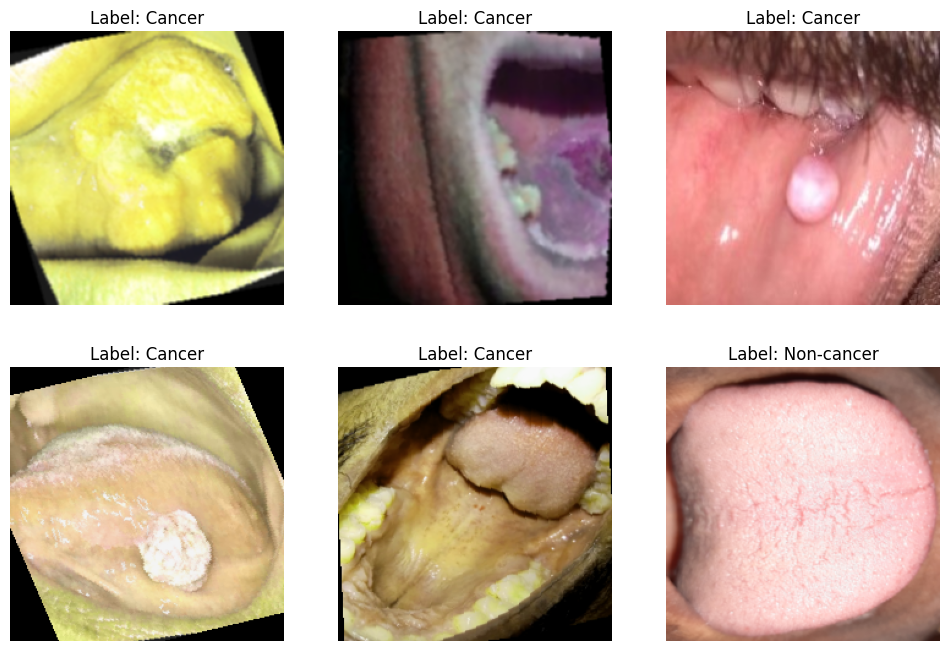

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import pandas as pd
import os
from torchvision import transforms
import matplotlib.pyplot as plt

# Load the new dataframe with image paths and labels
new_df = pd.read_csv('/content/new_augmented_dataset.csv')

# Custom Dataset class to load images from the dataframe
class AugmentedOralCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image path and label from the dataframe
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]

        # Open the image
        image = Image.open(img_path).convert('RGB')

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, label

# Define any necessary transformations for the images
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize all images to 224x224
    transforms.ToTensor(),            # Convert the image to PyTorch Tensor
])

# Instantiate the dataset with the new dataframe and transformations
augmented_dataset = AugmentedOralCancerDataset(dataframe=new_df, transform=image_transforms)

# Calculate the number of samples for each dataset
total_images = len(augmented_dataset)
train_size = int(0.7 * total_images)
val_size = int(0.15 * total_images)
test_size = total_images - train_size - val_size  # Remaining samples for the test set

# Generate shuffled indices
indices = np.random.permutation(total_images)

# Create subsets based on the shuffled indices
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create data samplers for each subset
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Create DataLoader for each subset
train_dataloader = DataLoader(augmented_dataset, batch_size=32, sampler=train_sampler)
val_dataloader = DataLoader(augmented_dataset, batch_size=32, sampler=val_sampler)
test_dataloader = DataLoader(augmented_dataset, batch_size=32, sampler=test_sampler)

# Function to display images
def show_images(images, labels, num_images=6):
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0)  # Convert the image back to (H, W, C) format
        label = labels[i].item()          # Get label value (0 or 1)

        plt.subplot(2, 3, i + 1)          # Create subplots (2 rows, 3 columns)
        plt.imshow(img)                   # Show image
        plt.title(f'Label: {"Cancer" if label == 1 else "Non-cancer"}')  # Show label
        plt.axis('off')                   # Hide axes
    plt.show()

# Iterate over the DataLoader and display a batch of images
for images, labels in train_dataloader:
    show_images(images, labels, num_images=6)  # Show 6 images
    break  # Break after the first batch to only display 6 images

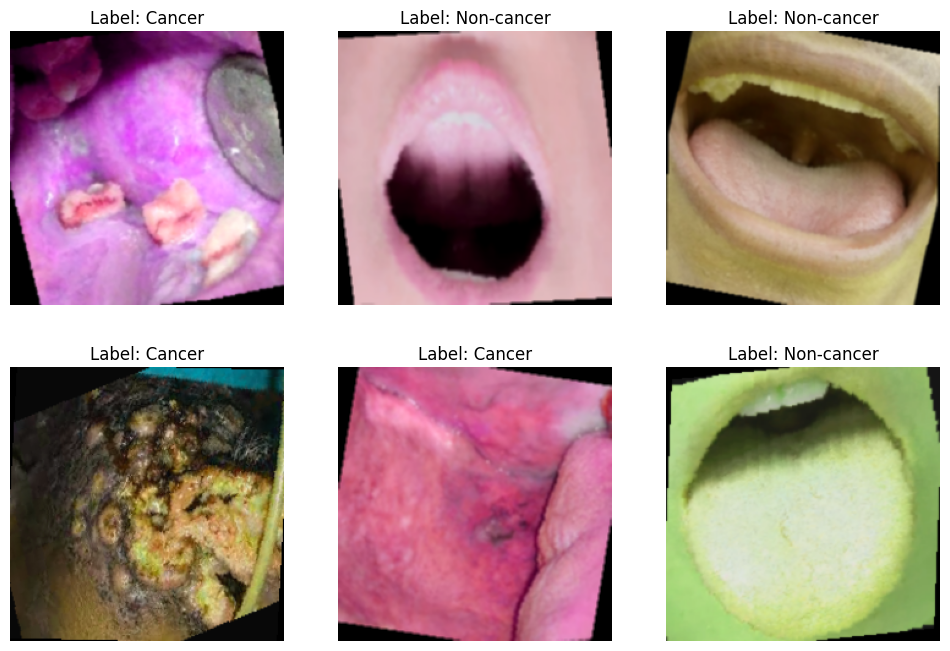

In [11]:
for images, labels in test_dataloader:
    show_images(images, labels, num_images=6)  # Show 6 images
    break  # Break after the first batch to only display 6 images

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import copy

# Define the ResNet Model class
class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        # Load the pre-trained ResNet-18 model
        self.model = models.resnet18(pretrained=True)
        # Replace the final fully connected layer to match the number of output classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of classes (assuming you have a dictionary or mapping for categories)
num_classes = 2  # Replace with your actual number of categories

# Instantiate the model
model_resnet18 = ResNetModel(num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=0.001)

# Early Stopping parameters
patience = 5  # Number of epochs to wait before stopping if no improvement
best_loss = float('inf')  # Initialize the best loss to infinity
best_model_wts = copy.deepcopy(model_resnet18.state_dict())  # Copy initial model weights
patience_counter = 0  # Counter to keep track of epochs with no improvement

# Training loop with Early Stopping
num_epochs = 50  # Set a larger number of epochs to allow early stopping to work
for epoch in range(num_epochs):
    model_resnet18.train()
    running_train_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_resnet18(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Validation phase
    model_resnet18.eval()
    running_valid_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_resnet18(images)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item()

    # Calculate average losses
    avg_train_loss = running_train_loss / len(train_dataloader)
    avg_valid_loss = running_valid_loss / len(val_dataloader)

    # Print losses for the current epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_valid_loss:.4f}')

    # Early Stopping logic
    if avg_valid_loss < best_loss:
        best_loss = avg_valid_loss
        best_model_wts = copy.deepcopy(model_resnet18.state_dict())
        patience_counter = 0  # Reset the counter if validation loss improves
    else:
        patience_counter += 1
        print(f'Early stopping counter: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Load the best model weights before saving
model_resnet18.load_state_dict(best_model_wts)

# Save the trained model
torch.save(model_resnet18.state_dict(), 'resnet_model_best.pth')

# Model summary (optional)
from torchsummary import summary
summary(model_resnet18, (3, 224, 224))  # ResNet expects 224x224 input images


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


Epoch [1/50], Train Loss: 0.3968, Val Loss: 0.4814
Epoch [2/50], Train Loss: 0.2092, Val Loss: 0.2808
Epoch [3/50], Train Loss: 0.1568, Val Loss: 0.2588
Epoch [4/50], Train Loss: 0.1401, Val Loss: 0.4807
Early stopping counter: 1/5
Epoch [5/50], Train Loss: 0.1043, Val Loss: 0.2051
Epoch [6/50], Train Loss: 0.0891, Val Loss: 0.3313
Early stopping counter: 1/5
Epoch [7/50], Train Loss: 0.0482, Val Loss: 0.5793
Early stopping counter: 2/5
Epoch [8/50], Train Loss: 0.1279, Val Loss: 0.2933
Early stopping counter: 3/5
Epoch [9/50], Train Loss: 0.0750, Val Loss: 0.2355
Early stopping counter: 4/5
Epoch [10/50], Train Loss: 0.0522, Val Loss: 0.5867
Early stopping counter: 5/5
Early stopping triggered
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 1

Confusion Matrix:
[[203  11]
 [ 17 263]]


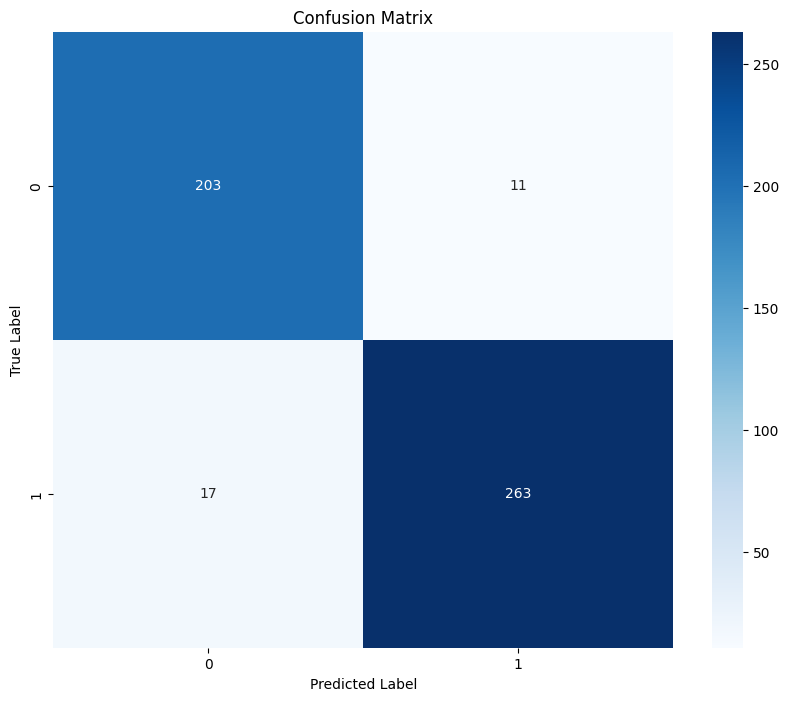

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      0.95      0.94       214
     Class 1       0.96      0.94      0.95       280

    accuracy                           0.94       494
   macro avg       0.94      0.94      0.94       494
weighted avg       0.94      0.94      0.94       494



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Lists to store all true labels and predictions
all_labels = []
all_predictions = []

# Perform evaluation to get predictions for the entire test set
model_resnet18.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet18(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(num_classes)]))

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
import copy

# Define ResNet-50 Model
class ResNet50Model(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Model, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of classes (assuming you have a dictionary or mapping for categories)
num_classes = 2  # Replace with your actual number of categories

# Instantiate the model
model_resnet50 = ResNet50Model(num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet50.parameters(), lr=0.001)

# Early Stopping parameters
patience = 5  # Number of epochs to wait before stopping if no improvement
best_loss = float('inf')  # Initialize the best loss to infinity
best_model_wts = copy.deepcopy(model_resnet50.state_dict())  # Copy initial model weights
patience_counter = 0  # Counter to keep track of epochs with no improvement

# Training loop with Early Stopping
num_epochs = 50  # Set a larger number of epochs to allow early stopping to work
for epoch in range(num_epochs):
    model_resnet50.train()
    running_train_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_resnet50(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Validation phase
    model_resnet50.eval()
    running_valid_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_resnet50(images)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item()

    # Calculate average losses
    avg_train_loss = running_train_loss / len(train_dataloader)
    avg_valid_loss = running_valid_loss / len(val_dataloader)

    # Print losses for the current epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_valid_loss:.4f}')

    # Early Stopping logic
    if avg_valid_loss < best_loss:
        best_loss = avg_valid_loss
        best_model_wts = copy.deepcopy(model_resnet50.state_dict())
        patience_counter = 0  # Reset the counter if validation loss improves
    else:
        patience_counter += 1
        print(f'Early stopping counter: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Load the best model weights before saving
model_resnet50.load_state_dict(best_model_wts)

# Save the trained model
torch.save(model_resnet50.state_dict(), 'resnet50_best.pth')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]


Epoch [1/50], Train Loss: 0.3605, Val Loss: 0.7107
Epoch [2/50], Train Loss: 0.2316, Val Loss: 0.2585
Epoch [3/50], Train Loss: 0.1520, Val Loss: 0.3022
Early stopping counter: 1/5
Epoch [4/50], Train Loss: 0.1130, Val Loss: 0.7165
Early stopping counter: 2/5
Epoch [5/50], Train Loss: 0.1405, Val Loss: 1.0783
Early stopping counter: 3/5
Epoch [6/50], Train Loss: 0.0868, Val Loss: 0.2274
Epoch [7/50], Train Loss: 0.0388, Val Loss: 0.3476
Early stopping counter: 1/5
Epoch [8/50], Train Loss: 0.1350, Val Loss: 0.2190
Epoch [9/50], Train Loss: 0.0854, Val Loss: 0.2443
Early stopping counter: 1/5
Epoch [10/50], Train Loss: 0.0623, Val Loss: 0.4289
Early stopping counter: 2/5
Epoch [11/50], Train Loss: 0.0810, Val Loss: 0.9905
Early stopping counter: 3/5
Epoch [12/50], Train Loss: 0.0462, Val Loss: 0.6011
Early stopping counter: 4/5
Epoch [13/50], Train Loss: 0.0647, Val Loss: 0.3256
Early stopping counter: 5/5
Early stopping triggered


Confusion Matrix:
[[178  36]
 [  6 274]]


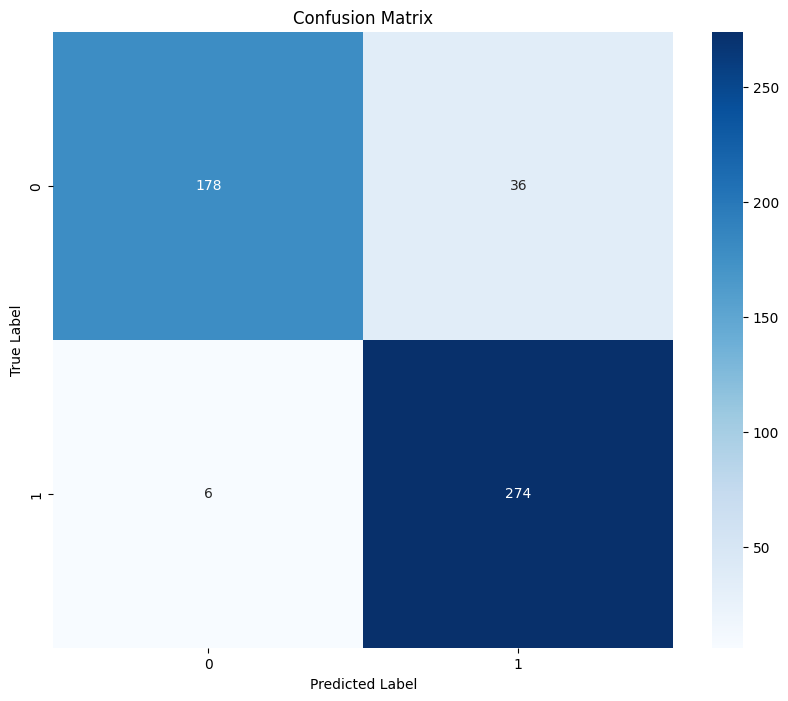

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.83      0.89       214
     Class 1       0.88      0.98      0.93       280

    accuracy                           0.91       494
   macro avg       0.93      0.91      0.91       494
weighted avg       0.92      0.91      0.91       494



In [15]:
# Lists to store all true labels and predictions
all_labels = []
all_predictions = []
num_classes = 2
# Perform evaluation to get predictions for the entire test set
model_resnet50.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet50(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(num_classes)]))

In [16]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import copy

# Define DenseNet121 Model
class DenseNet121Model(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet121Model, self).__init__()
        self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Instantiate the model
model_densenet121 = DenseNet121Model(num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_densenet121.parameters(), lr=0.001)

# Training loop with Early Stopping (Same as above, replace model_resnet50 with model_densenet121)
num_epochs = 50
best_loss = float('inf')
best_model_wts = copy.deepcopy(model_densenet121.state_dict())
patience_counter = 0

for epoch in range(num_epochs):
    model_densenet121.train()
    running_train_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_densenet121(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    model_densenet121.eval()
    running_valid_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_densenet121(images)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_dataloader)
    avg_valid_loss = running_valid_loss / len(val_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_valid_loss:.4f}')

    if avg_valid_loss < best_loss:
        best_loss = avg_valid_loss
        best_model_wts = copy.deepcopy(model_densenet121.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        print(f'Early stopping counter: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

model_densenet121.load_state_dict(best_model_wts)
torch.save(model_densenet121.state_dict(), 'densenet121_best.pth')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 193MB/s]


Epoch [1/50], Train Loss: 0.4120, Val Loss: 0.8249
Epoch [2/50], Train Loss: 0.2506, Val Loss: 0.2077
Epoch [3/50], Train Loss: 0.1925, Val Loss: 0.2170
Early stopping counter: 1/5
Epoch [4/50], Train Loss: 0.1601, Val Loss: 0.3020
Early stopping counter: 2/5
Epoch [5/50], Train Loss: 0.1309, Val Loss: 0.2678
Early stopping counter: 3/5
Epoch [6/50], Train Loss: 0.1722, Val Loss: 0.2509
Early stopping counter: 4/5
Epoch [7/50], Train Loss: 0.0962, Val Loss: 0.4329
Early stopping counter: 5/5
Early stopping triggered


Confusion Matrix:
[[199  15]
 [ 24 256]]


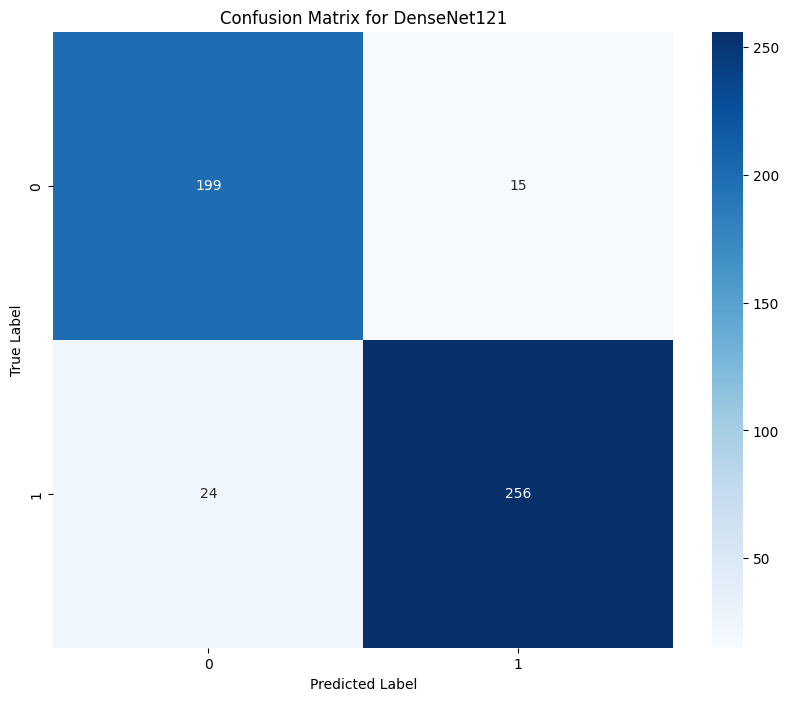

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.93      0.91       214
     Class 1       0.94      0.91      0.93       280

    accuracy                           0.92       494
   macro avg       0.92      0.92      0.92       494
weighted avg       0.92      0.92      0.92       494



In [17]:
# Lists to store all true labels and predictions
all_labels = []
all_predictions = []

# Perform evaluation to get predictions for the entire test set
model_densenet121.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_densenet121(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for DenseNet121')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(num_classes)]))

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
import copy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Define ResNet-101 Model
class ResNet101Model(nn.Module):
    def __init__(self, num_classes):
        super(ResNet101Model, self).__init__()
        self.model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Instantiate the ResNet-101 model
model_resnet101 = ResNet101Model(num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet101.parameters(), lr=0.001)

# Training loop with Early Stopping
num_epochs = 50
best_loss = float('inf')
best_model_wts = copy.deepcopy(model_resnet101.state_dict())
patience_counter = 0
patience = 5

for epoch in range(num_epochs):
    model_resnet101.train()
    running_train_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet101(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    model_resnet101.eval()
    running_valid_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_resnet101(images)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_dataloader)
    avg_valid_loss = running_valid_loss / len(val_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_valid_loss:.4f}')

    if avg_valid_loss < best_loss:
        best_loss = avg_valid_loss
        best_model_wts = copy.deepcopy(model_resnet101.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        print(f'Early stopping counter: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

model_resnet101.load_state_dict(best_model_wts)
torch.save(model_resnet101.state_dict(), 'resnet101_best.pth')

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 169MB/s]


Epoch [1/50], Train Loss: 0.3552, Val Loss: 0.5147
Epoch [2/50], Train Loss: 0.2478, Val Loss: 0.2370
Epoch [3/50], Train Loss: 0.1593, Val Loss: 0.4008
Early stopping counter: 1/5
Epoch [4/50], Train Loss: 0.1317, Val Loss: 0.3283
Early stopping counter: 2/5
Epoch [5/50], Train Loss: 0.1073, Val Loss: 0.1965
Epoch [6/50], Train Loss: 0.1095, Val Loss: 0.4532
Early stopping counter: 1/5
Epoch [7/50], Train Loss: 0.0703, Val Loss: 0.3705
Early stopping counter: 2/5
Epoch [8/50], Train Loss: 0.1164, Val Loss: 0.3525
Early stopping counter: 3/5
Epoch [9/50], Train Loss: 0.0442, Val Loss: 0.4799
Early stopping counter: 4/5
Epoch [10/50], Train Loss: 0.0767, Val Loss: 0.5933
Early stopping counter: 5/5
Early stopping triggered


Confusion Matrix for ResNet-101:
[[190  24]
 [ 22 258]]


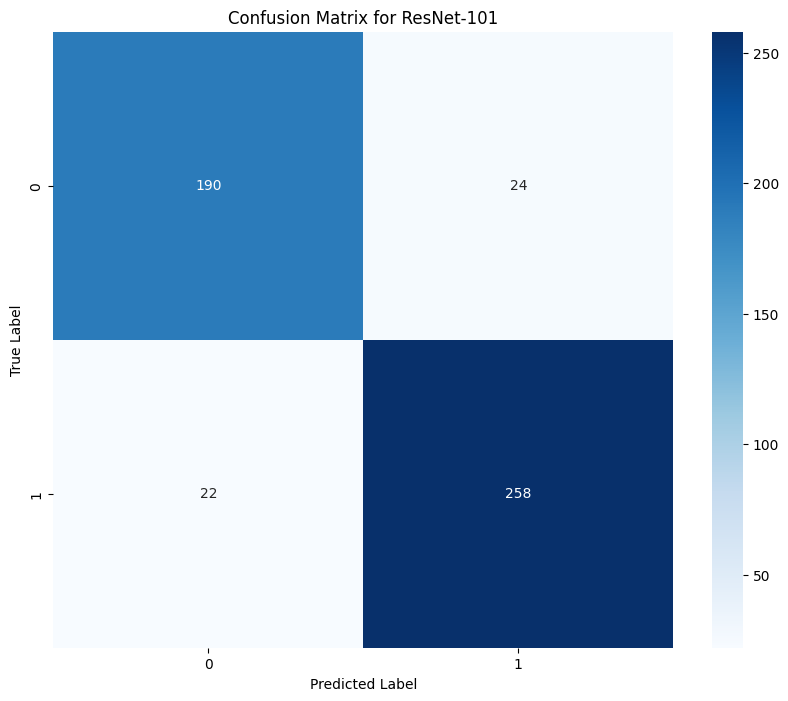

Classification Report for ResNet-101:
              precision    recall  f1-score   support

     Class 0       0.90      0.89      0.89       214
     Class 1       0.91      0.92      0.92       280

    accuracy                           0.91       494
   macro avg       0.91      0.90      0.91       494
weighted avg       0.91      0.91      0.91       494



In [21]:
# Evaluation for ResNet-101
all_labels = []
all_predictions = []

model_resnet101.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet101(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix for ResNet-101:")
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for ResNet-101')
plt.show()

# Classification Report
print("Classification Report for ResNet-101:")
print(classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(num_classes)]))

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
import copy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Define ResNet-152 Model
class ResNet152Model(nn.Module):
    def __init__(self, num_classes):
        super(ResNet152Model, self).__init__()
        self.model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Instantiate the ResNet-152 model
model_resnet152 = ResNet152Model(num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet152.parameters(), lr=0.001)

# Training loop with Early Stopping
num_epochs = 50
best_loss = float('inf')
best_model_wts = copy.deepcopy(model_resnet152.state_dict())
patience_counter = 0
patience = 5

for epoch in range(num_epochs):
    model_resnet152.train()
    running_train_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet152(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    model_resnet152.eval()
    running_valid_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_resnet152(images)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_dataloader)
    avg_valid_loss = running_valid_loss / len(val_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_valid_loss:.4f}')

    if avg_valid_loss < best_loss:
        best_loss = avg_valid_loss
        best_model_wts = copy.deepcopy(model_resnet152.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        print(f'Early stopping counter: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

model_resnet152.load_state_dict(best_model_wts)
torch.save(model_resnet152.state_dict(), 'resnet152_best.pth')

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 116MB/s]


Epoch [1/50], Train Loss: 0.3516, Val Loss: 0.5341
Epoch [2/50], Train Loss: 0.2480, Val Loss: 0.2611
Epoch [3/50], Train Loss: 0.1939, Val Loss: 0.2653
Early stopping counter: 1/5
Epoch [4/50], Train Loss: 0.1364, Val Loss: 0.2252
Epoch [5/50], Train Loss: 0.1100, Val Loss: 0.8325
Early stopping counter: 1/5
Epoch [6/50], Train Loss: 0.0813, Val Loss: 0.2543
Early stopping counter: 2/5
Epoch [7/50], Train Loss: 0.0970, Val Loss: 0.4459
Early stopping counter: 3/5
Epoch [8/50], Train Loss: 0.0498, Val Loss: 0.3606
Early stopping counter: 4/5
Epoch [9/50], Train Loss: 0.1050, Val Loss: 0.4678
Early stopping counter: 5/5
Early stopping triggered


Confusion Matrix for ResNet-152:
[[185  29]
 [ 17 263]]


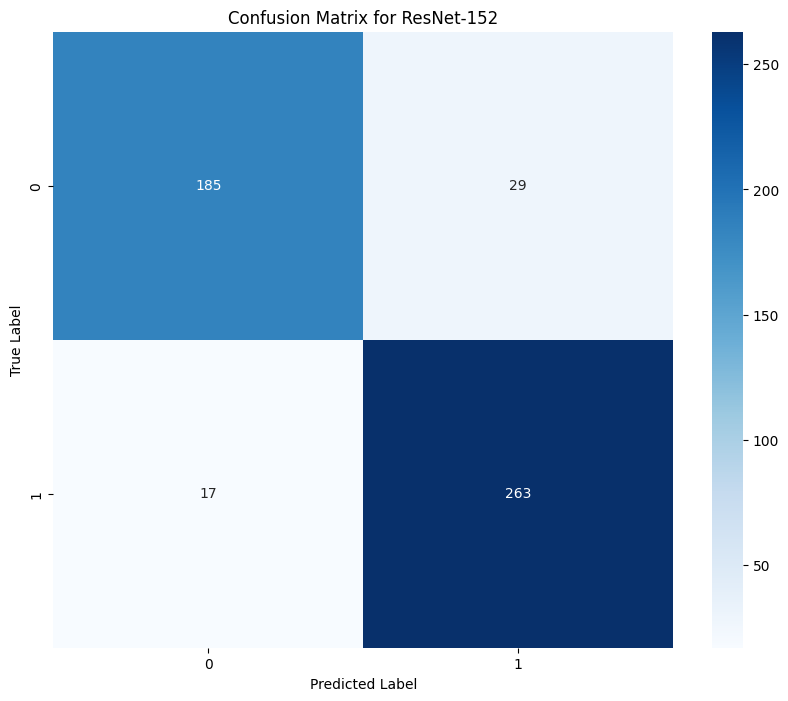

Classification Report for ResNet-152:
              precision    recall  f1-score   support

     Class 0       0.92      0.86      0.89       214
     Class 1       0.90      0.94      0.92       280

    accuracy                           0.91       494
   macro avg       0.91      0.90      0.90       494
weighted avg       0.91      0.91      0.91       494



In [23]:
# Evaluation for ResNet-152
all_labels = []
all_predictions = []

model_resnet152.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet152(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix for ResNet-152:")
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for ResNet-152')
plt.show()

# Classification Report
print("Classification Report for ResNet-152:")
print(classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(num_classes)]))


In [29]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import copy

# Define MobileNetV2 Model
class MobileNetV2Model(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2Model, self).__init__()
        self.model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Instantiate the model
model_mobilenetv2 = MobileNetV2Model(num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mobilenetv2.parameters(), lr=0.001)

# Training loop with Early Stopping (Same as above, replace model_resnet50 with model_mobilenetv2)
num_epochs = 50
best_loss = float('inf')
best_model_wts = copy.deepcopy(model_mobilenetv2.state_dict())
patience_counter = 0

for epoch in range(num_epochs):
    model_mobilenetv2.train()
    running_train_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_mobilenetv2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    model_mobilenetv2.eval()
    running_valid_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_mobilenetv2(images)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_dataloader)
    avg_valid_loss = running_valid_loss / len(val_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_valid_loss:.4f}')

    if avg_valid_loss < best_loss:
        best_loss = avg_valid_loss
        best_model_wts = copy.deepcopy(model_mobilenetv2.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        print(f'Early stopping counter: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

model_mobilenetv2.load_state_dict(best_model_wts)
torch.save(model_mobilenetv2.state_dict(), 'mobilenetv2_best.pth')

Epoch [1/50], Train Loss: 0.3058, Val Loss: 0.2822
Epoch [2/50], Train Loss: 0.1207, Val Loss: 0.1524
Epoch [3/50], Train Loss: 0.0697, Val Loss: 0.1986
Early stopping counter: 1/5
Epoch [4/50], Train Loss: 0.0902, Val Loss: 0.1508
Epoch [5/50], Train Loss: 0.0548, Val Loss: 0.1467
Epoch [6/50], Train Loss: 0.0279, Val Loss: 0.2777
Early stopping counter: 1/5
Epoch [7/50], Train Loss: 0.0846, Val Loss: 0.1507
Early stopping counter: 2/5
Epoch [8/50], Train Loss: 0.0688, Val Loss: 0.1899
Early stopping counter: 3/5
Epoch [9/50], Train Loss: 0.0304, Val Loss: 0.2133
Early stopping counter: 4/5
Epoch [10/50], Train Loss: 0.0476, Val Loss: 0.0956
Epoch [11/50], Train Loss: 0.0264, Val Loss: 0.0869
Epoch [12/50], Train Loss: 0.0035, Val Loss: 0.1071
Early stopping counter: 1/5
Epoch [13/50], Train Loss: 0.0025, Val Loss: 0.0857
Epoch [14/50], Train Loss: 0.0053, Val Loss: 0.1791
Early stopping counter: 1/5
Epoch [15/50], Train Loss: 0.0115, Val Loss: 0.1481
Early stopping counter: 2/5
Epoch

Confusion Matrix:
[[225   4]
 [  9 256]]


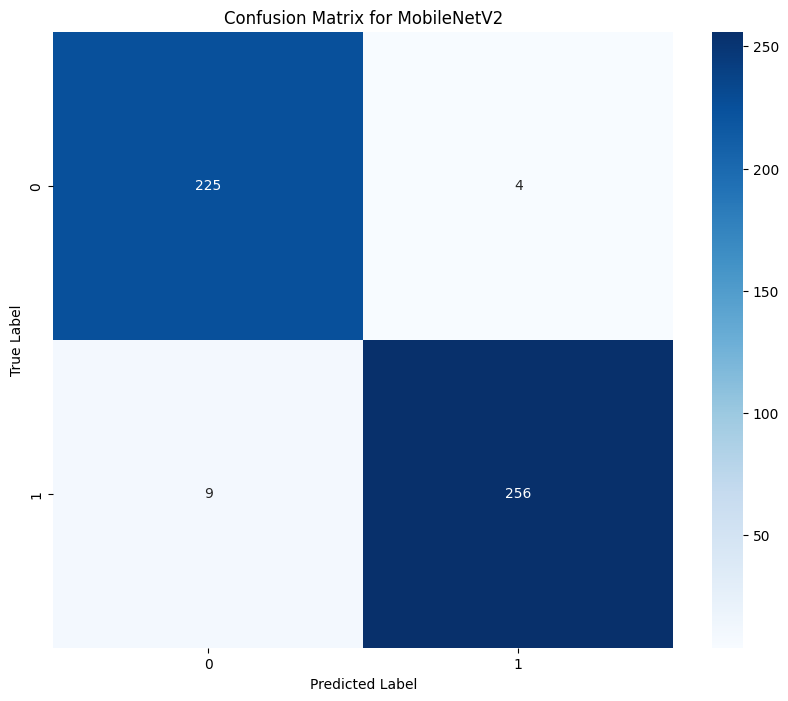

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.98      0.97       229
     Class 1       0.98      0.97      0.98       265

    accuracy                           0.97       494
   macro avg       0.97      0.97      0.97       494
weighted avg       0.97      0.97      0.97       494



In [30]:
# Lists to store all true labels and predictions
all_labels = []
all_predictions = []

# Perform evaluation to get predictions for the entire test set
model_mobilenetv2.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_mobilenetv2(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for MobileNetV2')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(num_classes)]))